# Import Library

In [ ]:
!pip install ibm-cos-sdk

In [ ]:
!pip install keras --upgrade

In [1]:
import numpy as np 
import pandas as pd 
import ibm_boto3
from botocore.client import Config

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
%matplotlib inline

Using TensorFlow backend.


### Unzip the input file and extract the filepaths

In [ ]:
from io import BytesIO
import zipfile

unzip = zipfile.ZipFile(BytesIO(streaming_body_1.read()),'r')
file_paths = unzip.namelist()
for path in file_paths:
    unzip.extract(path)

### The streaming_body_1 object will get saved in "/home/dsxuser/work" directory

# Prepare Training Data

In [2]:
import os

filenames = os.listdir('/home/dsxuser/work/train_Data/train')
categories = []
for filename in filenames:
    category = filename.split(' ')[0]
    if category == 'balasana':
        categories.append('balasana')
    elif category == 'garudasana':
        categories.append('garudasana')
    else :
        categories.append('marichyasana')
        
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

### Shuffle dataframe rows

In [3]:
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
len(filenames)

30

In [5]:
df.head(10)

,filename,category
0,balasana 403.jpg,balasana
1,balasana 409.jpg,balasana
2,marichyasana 201.jpg,marichyasana
3,balasana 404.jpg,balasana
4,marichyasana 203.jpg,marichyasana
5,balasana 402.jpg,balasana
6,balasana 406.jpg,balasana
7,garudasana 6.jpg,garudasana
8,marichyasana 200.jpg,marichyasana
9,balasana 400.jpg,balasana


In [6]:
df.tail(10)

,filename,category
20,garudasana 4.jpg,garudasana
21,marichyasana 207.jpg,marichyasana
22,marichyasana 209.jpg,marichyasana
23,balasana 408.jpg,balasana
24,marichyasana 206.jpg,marichyasana
25,garudasana 3.jpg,garudasana
26,balasana 405.jpg,balasana
27,garudasana 2.jpg,garudasana
28,balasana 407.jpg,balasana
29,garudasana 7.jpg,garudasana


### See Total In count

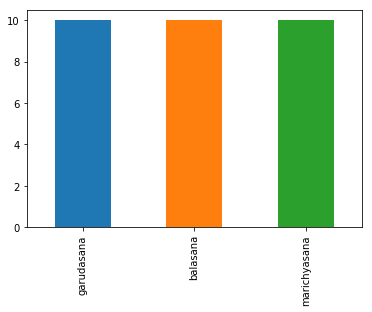

In [7]:
df['category'].value_counts().plot.bar()

From our data we have 10 images each of garudasana, balasana & marichyasana

# See sample image

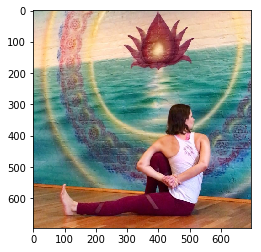

In [8]:
sample = random.choice(filenames)
image = load_img("/home/dsxuser/work/train_Data/train/"+sample)
plt.imshow(image)

In [9]:
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_2

# Callbacks

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and if val_loss value has not decreased.

In [11]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy does not increase for 2 steps

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [13]:
callbacks = [earlystop, learning_rate_reduction]

### Prepare Test and Train Data

In [14]:
train_df, validate_df = train_test_split(df, test_size=0.30, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

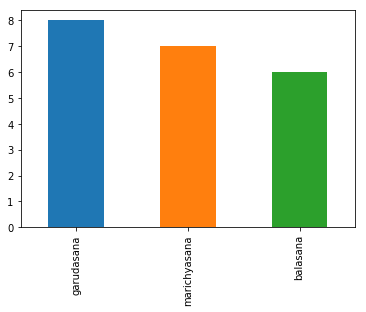

In [15]:
train_df['category'].value_counts().plot.bar()

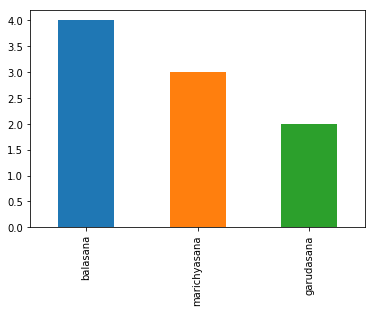

In [16]:
validate_df['category'].value_counts().plot.bar()

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=1

# Training Generator

In [18]:
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/home/dsxuser/work/train_Data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

Found 21 validated image filenames belonging to 3 classes.


### Validation Generator

In [19]:
validation_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/home/dsxuser/work/train_Data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

Found 9 validated image filenames belonging to 3 classes.


# See how our generator work

In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/home/dsxuser/work/train_Data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


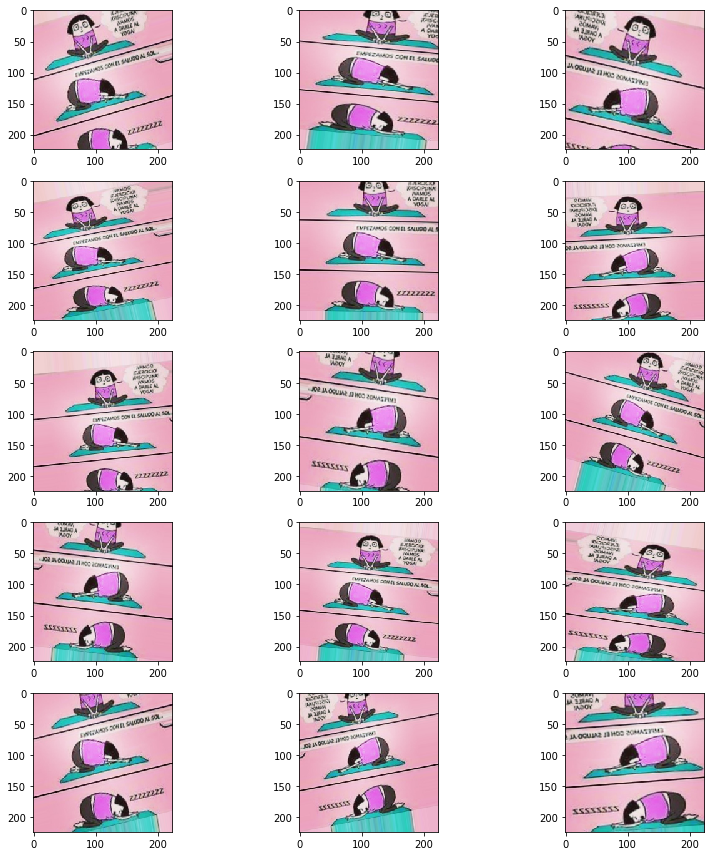

In [21]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Looks good!

# Fit Model

In [22]:
epochs=3 if FAST_RUN else 15
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=20,
    steps_per_epoch=50,
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
50/50 [==============================] - 28s 552ms/step - loss: 1.1013 - acc: 0.3600 - val_loss: 4.7003 - val_acc: 0.4500
Epoch 2/15
50/50 [==============================] - 27s 534ms/step - loss: 1.1032 - acc: 0.3400 - val_loss: 6.6232 - val_acc: 0.4500
Epoch 3/15
50/50 [==============================] - 26s 521ms/step - loss: 1.0985 - acc: 0.3600 - val_loss: 5.0741 - val_acc: 0.4500

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/15
50/50 [==============================] - 26s 519ms/step - loss: 1.0956 - acc: 0.3800 - val_loss: 5.9157 - val_acc: 0.4000
Epoch 5/15
50/50 [==============================] - 26s 519ms/step - loss: 1.0933 - acc: 0.4000 - val_loss: 5.3046 - val_acc: 0.4500

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/15
50/50 [==============================] - 26s 521ms/step - loss: 1.0960 - acc: 0.3800 - val_loss: 5.2474 - val_acc:

### Run the below cell only to use Pre-Trained VGG-16 Model, otherwise omit this step

In [ ]:
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.applications.vgg16 import VGG16



vgg16_model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
vgg16_model.summary()
type(vgg16_model) 
model = Sequential() 
for layer in vgg16_model.layers:
    model.add(layer)
model.layers.pop()
model.summary()
for layer in model.layers: 
    layer.trainable = False
model.add(Dense(9, activation='sigmoid')) 
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Evaluate Model Accuracy

In [25]:
Validation_Accuracy = model.evaluate_generator(generator=validation_generator, steps=20)

In [26]:
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))

The Model Accuracy for Validation data is:  40.00%


# Virtualize Training

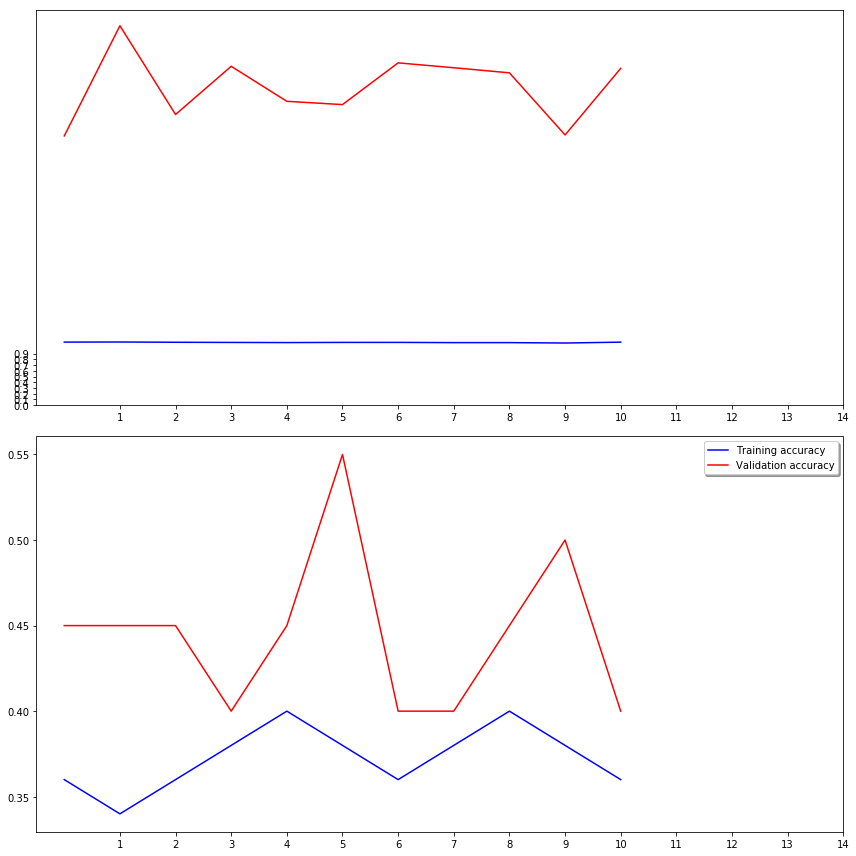

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [28]:
test_filenames = os.listdir("/home/dsxuser/work/train_Data/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [29]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/home/dsxuser/work/train_Data/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=1,
    shuffle=False
)

Found 15 validated image filenames.


In [30]:
nb_samples

15

# Predict

In [31]:
test_generator.reset()
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [32]:
predicted_class_indices=np.argmax(predict,axis=1)

In [33]:
predicted_class_indices

array([0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [35]:
predictions

['balasana',
 'balasana',
 'balasana',
 'marichyasana',
 'balasana',
 'balasana',
 'balasana',
 'balasana',
 'balasana',
 'balasana',
 'balasana',
 'balasana',
 'balasana',
 'balasana',
 'balasana']

In [36]:
filenames=test_generator.filenames
results=pd.DataFrame({"True Filename":filenames,
                      "Predicted Filename":predictions})
print(results)

           True Filename Predicted Filename
0   marichyasana 354.jpg           balasana
1     garudasana 161.jpg           balasana
2       balasana 550.jpg           balasana
3       balasana 551.jpg       marichyasana
4     garudasana 160.jpg           balasana
5     garudasana 162.jpg           balasana
6       balasana 553.jpg           balasana
7       balasana 552.jpg           balasana
8     garudasana 163.jpg           balasana
9   marichyasana 352.jpg           balasana
10  marichyasana 353.jpg           balasana
11  marichyasana 351.jpg           balasana
12    garudasana 164.jpg           balasana
13      balasana 554.jpg           balasana
14  marichyasana 350.jpg           balasana


### See predicted result with images

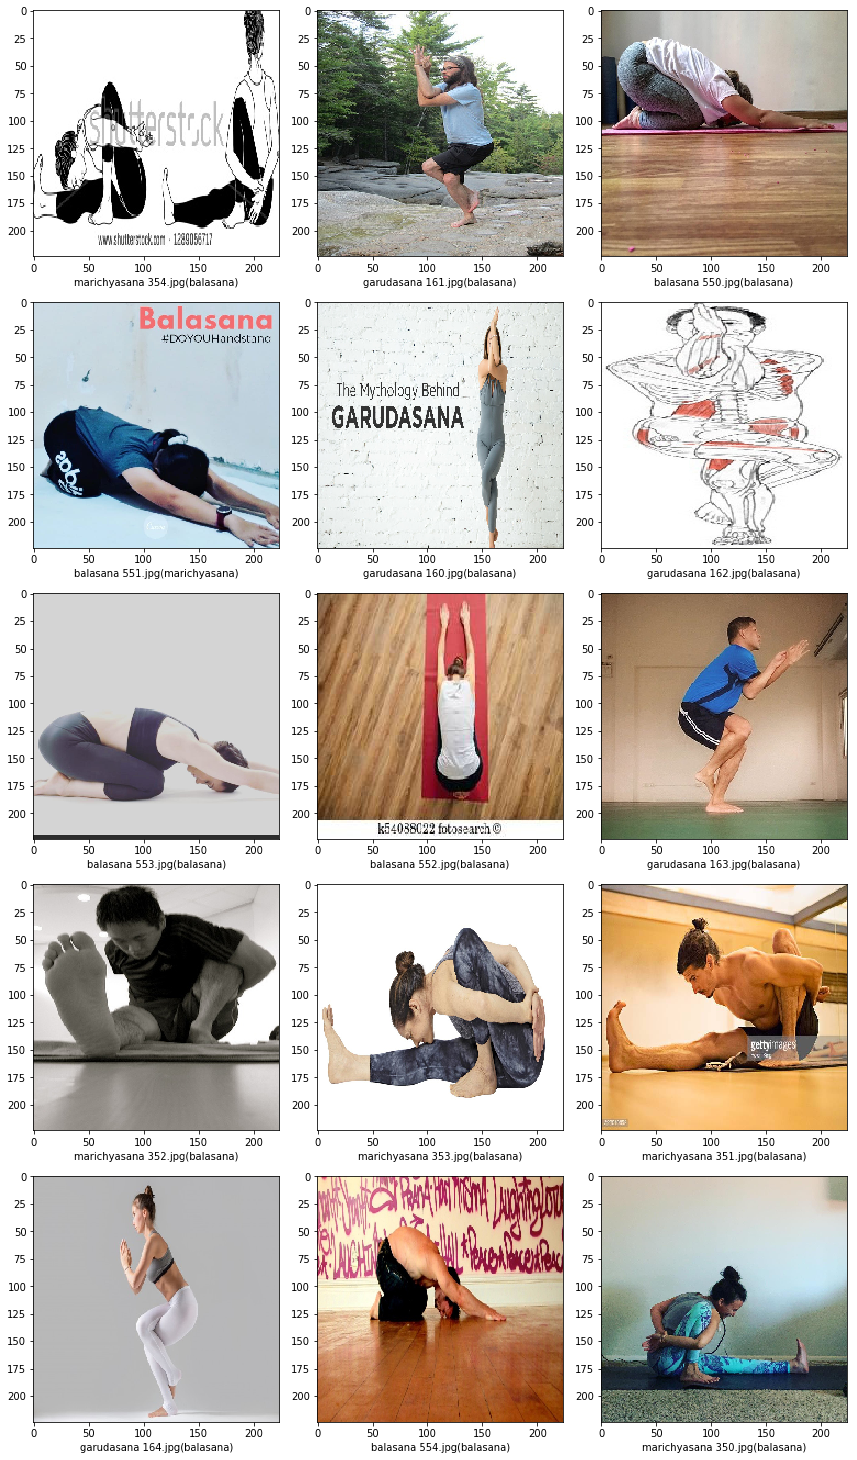

In [37]:
sample_test = results.head(15)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['True Filename']
    predictions = row['Predicted Filename']
    img = load_img("/home/dsxuser/work/train_Data/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(predictions) + ')')
plt.tight_layout()
plt.show()

# Submission

In [38]:
submission_df = results.copy()
submission_df.to_csv('submission.csv', index=False)

### Insert credentials

In [ ]:
cos = ibm_boto3.client('s3',
                    ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
                    ibm_service_instance_id=credentials_1['IAM_SERVICE_ID'],
                    ibm_auth_endpoint=credentials_1['IBM_AUTH_ENDPOINT'],
                    config=Config(signature_version='oauth'),
                    endpoint_url=credentials_1['ENDPOINT'])

def get_file(filename):
    '''Retrieve file from Cloud Object Storage'''
    fileobject = cos.get_object(Bucket=credentials_1['BUCKET'], Key=filename)['Body']
    return fileobject

def put_file(filepath, filename):
    '''Write file (csv, zip, pkl) to Cloud Object Storage'''
    resp = cos.upload_file(Filename=filepath,Bucket=credentials_1['BUCKET'],Key=filename)
    return resp

### Write the results to cloud object storage

In [ ]:
filepath = '/home/dsxuser/work/submission.csv'
filename = 'Submission_results.csv'
put_file(filepath, filename)